# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


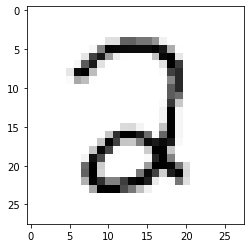

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.248
Training Accuracy: 0.6345, Testing Accuracy: 0.5927



Epoch 10, Loss 0.1051
Training Accuracy: 0.9064, Testing Accuracy: 0.9118



Epoch 20, Loss 0.0636
Training Accuracy: 0.9324, Testing Accuracy: 0.9430



Epoch 30, Loss 0.0494
Training Accuracy: 0.9447, Testing Accuracy: 0.9561



Epoch 40, Loss 0.0422
Training Accuracy: 0.9519, Testing Accuracy: 0.9587



Epoch 50, Loss 0.0379
Training Accuracy: 0.9552, Testing Accuracy: 0.9617



Epoch 60, Loss 0.035
Training Accuracy: 0.9581, Testing Accuracy: 0.9637



Epoch 70, Loss 0.0328
Training Accuracy: 0.9612, Testing Accuracy: 0.9672



Epoch 80, Loss 0.0311
Training Accuracy: 0.9629, Testing Accuracy: 0.9662



Epoch 90, Loss 0.0297
Training Accuracy: 0.9644, Testing Accuracy: 0.9662



Epoch 100, Loss 0.0286
Training Accuracy: 0.9659, Testing Accuracy: 0.9662



Epoch 110, Loss 0.0276
Training Accuracy: 0.9673, Testing Accuracy: 0.9682



Epoch 120, Loss 0.0267
Training Accuracy: 0.9680, Testing Accuracy: 0.9693



Epoch 130, Loss 0.026
Training Accuracy: 0.9692, Testing Accuracy: 0.9698



Epoch 140, Loss 0.0253
Training Accuracy: 0.9706, Testing Accuracy: 0.9698



Epoch 150, Loss 0.0247
Training Accuracy: 0.9715, Testing Accuracy: 0.9708



Epoch 160, Loss 0.0241
Training Accuracy: 0.9723, Testing Accuracy: 0.9708



Epoch 170, Loss 0.0236
Training Accuracy: 0.9732, Testing Accuracy: 0.9708



Epoch 180, Loss 0.0231
Training Accuracy: 0.9737, Testing Accuracy: 0.9708



Epoch 190, Loss 0.0227
Training Accuracy: 0.9740, Testing Accuracy: 0.9718



Epoch 200, Loss 0.0222
Training Accuracy: 0.9750, Testing Accuracy: 0.9713



Epoch 210, Loss 0.0218
Training Accuracy: 0.9752, Testing Accuracy: 0.9723



Epoch 220, Loss 0.0215
Training Accuracy: 0.9755, Testing Accuracy: 0.9728



Epoch 230, Loss 0.0211
Training Accuracy: 0.9759, Testing Accuracy: 0.9723



Epoch 240, Loss 0.0207
Training Accuracy: 0.9764, Testing Accuracy: 0.9733



0.008422134632138135

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2524
Training Accuracy: 0.6370, Testing Accuracy: 0.6341



Epoch 10, Loss 0.1056
Training Accuracy: 0.9082, Testing Accuracy: 0.9138



Epoch 20, Loss 0.0801
Training Accuracy: 0.9303, Testing Accuracy: 0.9360



Epoch 30, Loss 0.0685
Training Accuracy: 0.9369, Testing Accuracy: 0.9481



Epoch 40, Loss 0.0617
Training Accuracy: 0.9412, Testing Accuracy: 0.9521



Epoch 50, Loss 0.0571
Training Accuracy: 0.9445, Testing Accuracy: 0.9546



Epoch 60, Loss 0.0538
Training Accuracy: 0.9467, Testing Accuracy: 0.9587



Epoch 70, Loss 0.0512
Training Accuracy: 0.9491, Testing Accuracy: 0.9592



Epoch 80, Loss 0.0492
Training Accuracy: 0.9506, Testing Accuracy: 0.9592



Epoch 90, Loss 0.0475
Training Accuracy: 0.9526, Testing Accuracy: 0.9597



Epoch 100, Loss 0.046
Training Accuracy: 0.9538, Testing Accuracy: 0.9597



Epoch 110, Loss 0.0448
Training Accuracy: 0.9550, Testing Accuracy: 0.9607



Epoch 120, Loss 0.0438
Training Accuracy: 0.9558, Testing Accuracy: 0.9612



Epoch 130, Loss 0.0428
Training Accuracy: 0.9560, Testing Accuracy: 0.9612



Epoch 140, Loss 0.042
Training Accuracy: 0.9565, Testing Accuracy: 0.9612



Epoch 150, Loss 0.0413
Training Accuracy: 0.9570, Testing Accuracy: 0.9632



Epoch 160, Loss 0.0406
Training Accuracy: 0.9575, Testing Accuracy: 0.9632



Epoch 170, Loss 0.04
Training Accuracy: 0.9578, Testing Accuracy: 0.9642



Epoch 180, Loss 0.0394
Training Accuracy: 0.9582, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0389
Training Accuracy: 0.9587, Testing Accuracy: 0.9647



Epoch 200, Loss 0.0384
Training Accuracy: 0.9590, Testing Accuracy: 0.9652



Epoch 210, Loss 0.038
Training Accuracy: 0.9591, Testing Accuracy: 0.9662



Epoch 220, Loss 0.0376
Training Accuracy: 0.9596, Testing Accuracy: 0.9662



Epoch 230, Loss 0.0372
Training Accuracy: 0.9599, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0368
Training Accuracy: 0.9608, Testing Accuracy: 0.9677



0.030851209465726608

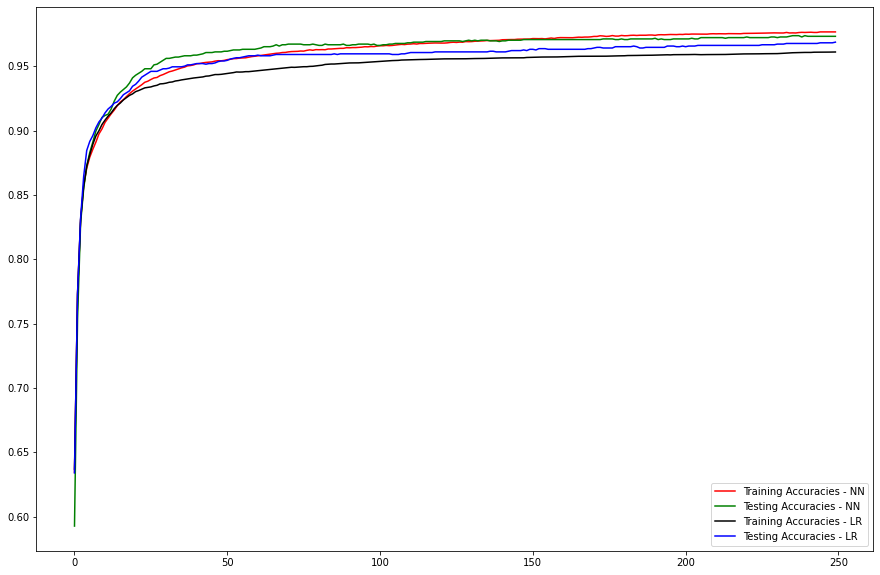

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

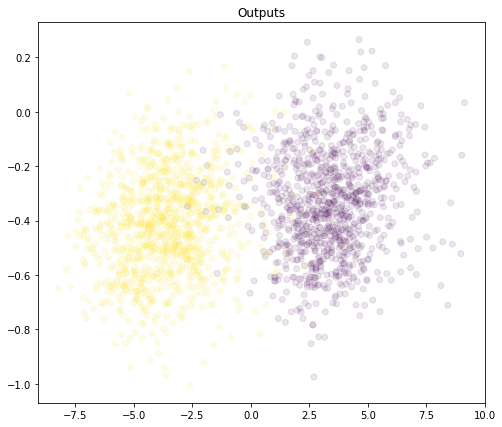

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

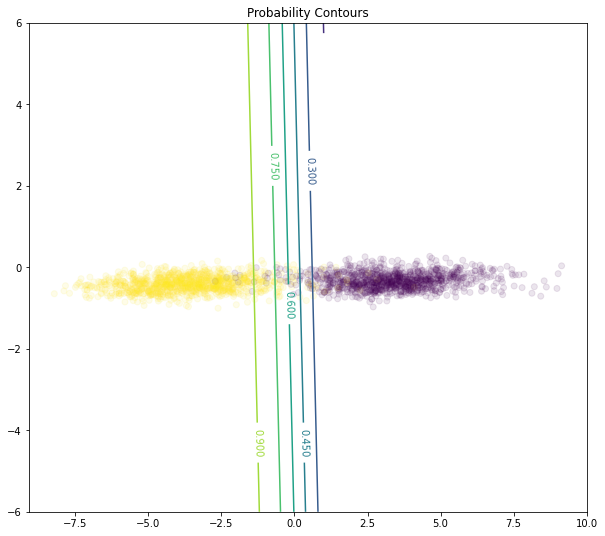

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );